In [1]:
pip install kornia

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 705.7/705.7 kB 9.4 MB/s eta 0:00:00


In [2]:
import kornia as K
import torch
import cv2
import matplotlib.pyplot as plt
from kornia.contrib.visual_prompter import VisualPrompter
from kornia.geometry.keypoints import Keypoints
from kornia.geometry.boxes import Boxes
from kornia.contrib.models import SegmentationResults
from kornia.utils import tensor_to_image

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
def load_torch_image(file_name):
    image = K.image_to_tensor(cv2.imread(file_name), False).float() / 255
    image = K.color.bgr_to_rgb(image)
    return image


def show_image(tensor):
    image = K.utils.tensor_to_image(tensor)
    plt.imshow(image)
    plt.axis('off')
    plt.show()

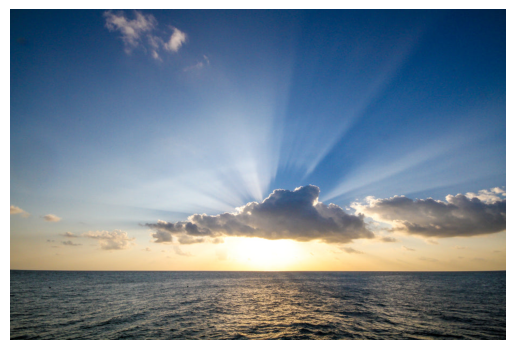

In [5]:
# Загрузим наши изображения
path_to_img = "drive/MyDrive/Colab Notebooks/"
image_1 = load_torch_image(path_to_img + "image_sea.jpg")

show_image(image_1)

In [6]:
if torch.cuda.is_available():
   print("Training on GPU")
   device = torch.device("cuda:0")
else:
     print("Training on CPU")
     device = torch.device("cpu")

Training on CPU


In [7]:
# Load the prompter
prompter = VisualPrompter()

# set the image: This will preprocess the image and already generate the embeddings of it
prompter.set_image(torch.squeeze(image_1))

Downloading: "https://dl.fbaipublicfiles.com/segment_anything/sam_vit_h_4b8939.pth" to /root/.cache/torch/hub/checkpoints/sam_vit_h_4b8939.pth
100%|██████████| 2.39G/2.39G [00:27<00:00, 91.6MB/s]


In [8]:
# Generate the prompts
keypoints = Keypoints(torch.tensor([[[100.0, 100.0], [225.0, 475.0], [485.0, 450.0], [547.0, 384.0], [10.0, 600.0], [100.0, 590.0], [200.0, 580.0], [485.0, 566.0]]], device=device, dtype=torch.float32)) # BxNx2
print(keypoints.shape)
# For the keypoints label: 1 indicates a foreground point; 0 indicates a background point
# keypoints_labels = torch.tensor([[1]], device=device) # BxN

labels = torch.zeros(keypoints.shape[:2], device=device, dtype=torch.float32)

labels_to_query = labels.clone()
labels_to_query[..., 4:] = 1

# Runs the prediction with the kypoints prompts
prediction = prompter.predict(
   keypoints=keypoints,
   keypoints_labels=labels_to_query,
   multimask_output=False, output_original_size=True
)

torch.Size([1, 8, 2])


In [9]:
def colorize_masks(binary_masks: torch.Tensor, merge: bool = True, alpha: None | float = None) -> list[torch.Tensor]:
    """Convert binary masks (B, C, H, W), boolean tensors, into masks with colors (B, (3, 4) , H, W) - RGB or RGBA. Where C refers to the number of masks.
    Args:
        binary_masks: a batched boolean tensor (B, C, H, W)
        merge: If true, will join the batch dimension into a unique mask.
        alpha: alpha channel value. If None, will generate RGB images

    Returns:
        A list of `C` colored masks.
    """
    B, C, H, W = binary_masks.shape
    OUT_C = 4 if alpha else 3

    output_masks = []

    for idx in range(C):
        _out = torch.zeros(B, OUT_C, H, W, device=binary_masks.device, dtype=torch.float32)
        for b in range(B):
            color = torch.rand(1, 3, 1, 1, device=binary_masks.device, dtype=torch.float32)
            if alpha:
                color = torch.cat([color, torch.tensor([[[[alpha]]]], device=binary_masks.device, dtype=torch.float32)], dim=1)

            to_colorize = binary_masks[b, idx, ...].view(1, 1, H, W).repeat(1, OUT_C, 1, 1)
            _out[b, ...] = torch.where(to_colorize, color, _out[b, ...])
        output_masks.append(_out)

    if merge:
        output_masks = [c.max(dim=0)[0] for c in output_masks]

    return output_masks


def show_binary_masks(binary_masks: torch.Tensor, axes) -> None:
    """plot binary masks, with shape (B, C, H, W), where C refers to the number of masks.

    will merge the `B` channel into a unique mask.
    Args:
        binary_masks: a batched boolean tensor (B, C, H, W)
        ax: a list of matplotlib axes with lenght of C
    """
    colored_masks = colorize_masks(binary_masks, True, 1.0)

    for ax, mask in zip(axes, colored_masks):
        ax.imshow(tensor_to_image(mask))


def show_boxes(boxes: Boxes, ax) -> None:
    boxes_tensor = boxes.to_tensor(mode="xywh").detach().cpu().numpy()
    for batched_boxes in boxes_tensor:
        for box in batched_boxes:
            x0, y0, w, h = box
            ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor="orange", facecolor=(0, 0, 0, 0), lw=2))


def show_points(points: tuple[Keypoints, torch.Tensor], ax, marker_size=200):
    coords, labels = points
    pos_points = coords[labels == 1].to_tensor().detach().cpu().numpy()
    neg_points = coords[labels == 0].to_tensor().detach().cpu().numpy()

    ax.scatter(pos_points[:, 0], pos_points[:, 1], color="green", marker="+", s=marker_size, linewidth=2)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color="red", marker="x", s=marker_size, linewidth=2)



def show_predictions(
    image: torch.Tensor,
    predictions: SegmentationResults,
    points: tuple[Keypoints, torch.Tensor] | None = None,
    boxes: Boxes | None = None,
) -> None:
    n_masks = predictions.logits.shape[1]

    fig, axes = plt.subplots(1, n_masks, figsize=(21, 16))
    axes = [axes] if n_masks == 1 else axes

    for idx, ax in enumerate(axes):
        score = predictions.scores[:, idx, ...].mean()
        ax.imshow(tensor_to_image(image))
        ax.set_title(f"Mask {idx+1}, Score: {score:.3f}", fontsize=18)

        if points:
            show_points(points, ax)

        if boxes:
            show_boxes(boxes, ax)

        ax.axis("off")

    show_binary_masks(predictions.binary_masks, axes)
    plt.show()

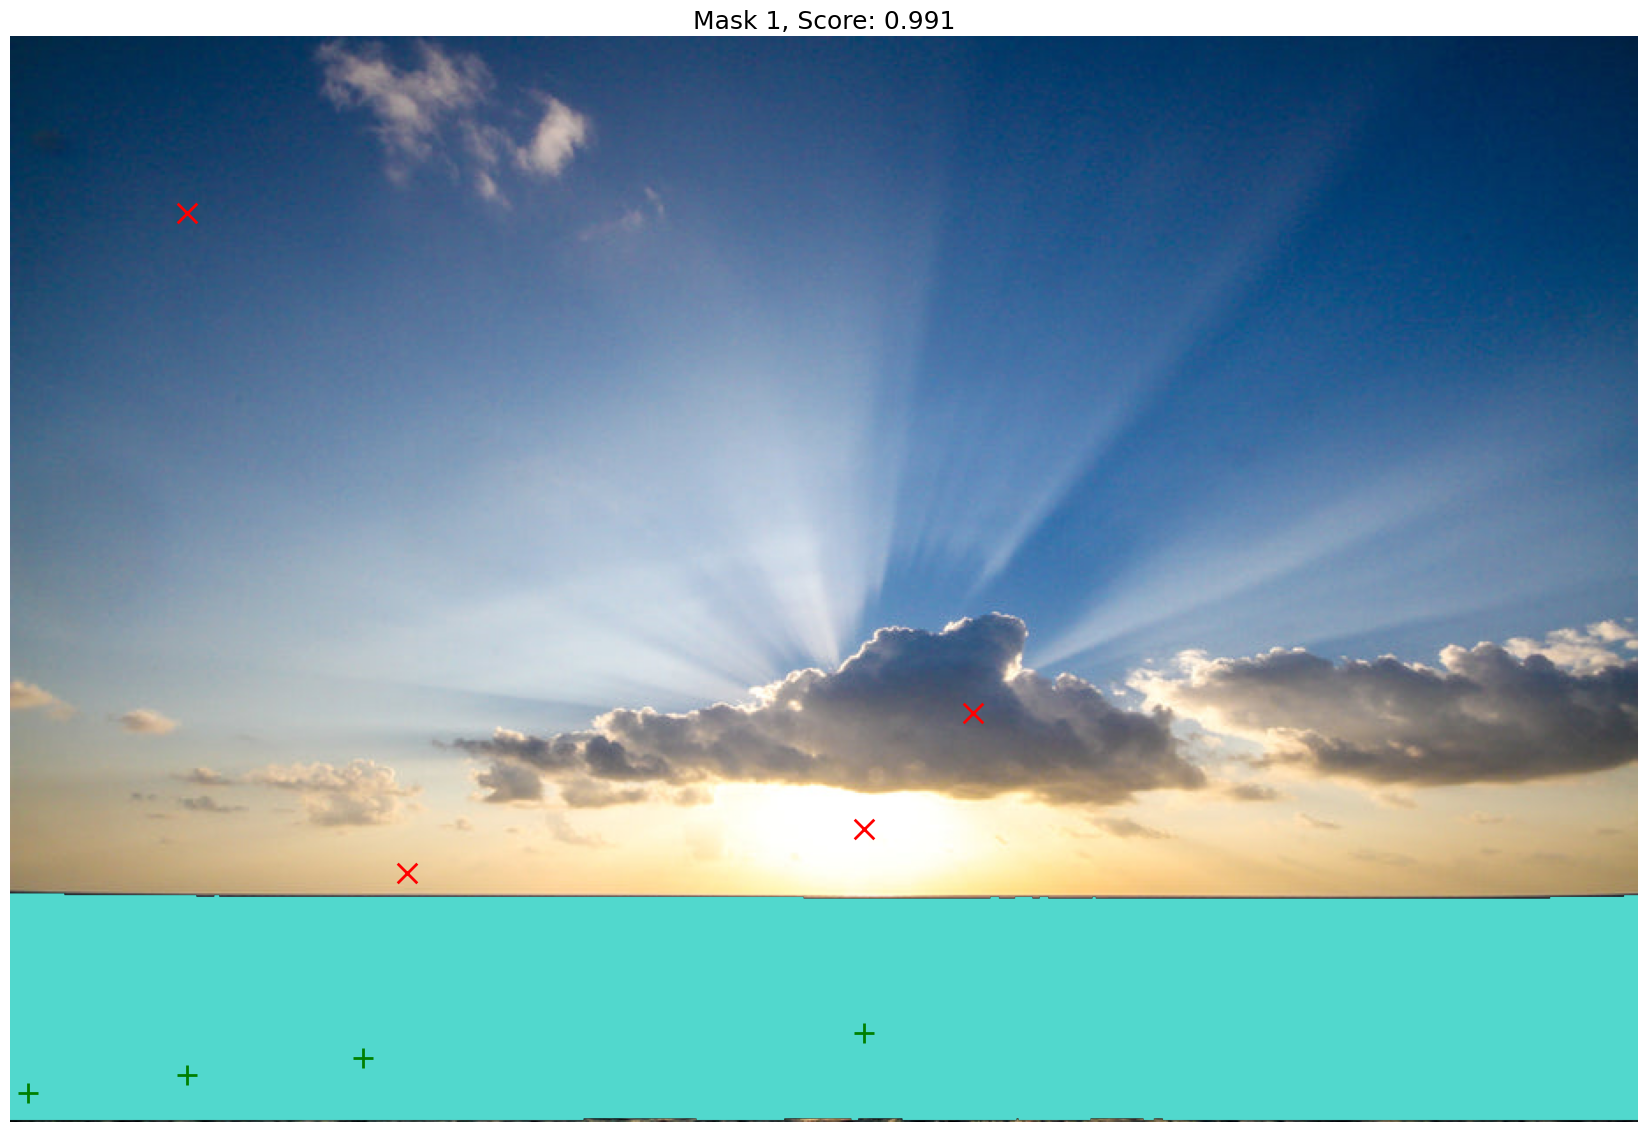

In [10]:
show_predictions(image_1, prediction, points=(keypoints, labels_to_query))